# Milestone P4: Team KLR - Extending the comparison of classification models for rare civil war onsets

This notebook serves as an extension of Comparing Random Forest with Logistic Regression for Predicting Class-Imbalanced Civil War Onset Data by Muchlinski David, Siroky David, He Jingrui & Kocher Matthew (2016). In similar fashion as Muchlinski et al., 2016, we aim to contribute to the insofar discarded predictive statistical methods in political science, in favor of accurately predicting significant events such as civil wars. To this end, Muchlinski et al., 2016's approach of comparing experimental performance of algorithmic maneuveurs via a multitude of metrics is adopted. However, in contrast with only using Random Forest and near-arbitrarily selecting features, we attempt in our paper to explore and implement additional feature-selection and classification methods through rigorous incorporation of boosting, and a variety of classification algorithms, as well as on and offline feature selection, which benefit an extended, deepened comparison and discussion surrounding not only this imbalanced prediction task, but also the causal estimation of features. While indeed from Muchlinski et al., 2016, it seems that Random Forests drastically outperform their determined competitor in all metrics employed, nuance of their strengths and weaknesses in contrast with more suited models remains uninvestigated, providing justification for extending this analysis.

First, we implement on-and-offline feature selection methods building on Muchlisnki' et al's comparison of Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). From which we would like to uncover how feature selection methods serve to aid model performance. The .txt file `notes.txt` contains which variables were used originally by Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). We first retrieve these and later compare performance with and without arbitrary feature selection. 

In [1]:
!cat './data/notes.txt'

The main dataset you have to use is `SambnisImp.csv`.
Additionally, the provided `Sambanis Codebook.pdf` file contains a textual
description of (most) used variables.

---

When loading the data for replication purposes, note that the authors only
load the following 91 variables:

    "warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4"

In [30]:
# import necessary libraries, define data path, and other hard-coded variables
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

DATA_PATH = './data/'
seed = 7

# Extract features used in each paper from notes.txt 
with open(DATA_PATH+'notes.txt') as f:
    
    task_notes = f.readlines()
    task_notes = ''.join(task_notes)
    
    fl_feature_names = re.search(r'(?<=Fearon and Laitin \(2003\):)[^.\.]*',task_notes).group()
    fl_feature_names = re.sub('\n|\s|\"','',fl_feature_names).split(',')
    
    ch_feature_names = re.search(r'(?<=Collier and Hoeffler \(2004\):)[^.\.]*',task_notes).group()
    ch_feature_names = re.sub('\n|\s|\"','',ch_feature_names).split(',')

    hs_feature_names = re.search(r'(?<=Hegre and Sambanis \(2006\):)[^.\.]*',task_notes).group()
    hs_feature_names = re.sub('\n|\s|\"','',hs_feature_names).split(',')

# load data
master_data = pd.read_csv(DATA_PATH+'SambnisImp.csv', index_col='X')

# split data into features used for each paper and retrieve regressand 
y_master = master_data['warstds']

fl_x = master_data[fl_feature_names]
ch_x = master_data[ch_feature_names]
hs_x = master_data[hs_feature_names]

## Things to implement: 

- Chi squared offline feature selection
- Online feature selection

In [72]:
def compute_roc_vals(X, y, pipeline):
    
    # set seed and ensure input are numpy arrays
    np.random.seed(seed)
    X, y = X.to_numpy(), y.to_numpy()
    
    # If logistic regression, compute best regularization weight and set it
    if 'logisticregression' in log_pipeline.named_steps:
    
        n_grid_search = 5
        r_lambda = LogisticRegressionCV(Cs = n_grid_search, cv=10, max_iter=10000, scoring='roc_auc', random_state = seed).fit(X, y)
        pipeline['logisticregression'].set_params(C = r_lambda.C_[0], random_state = seed)
        
        # Predict the probabilities with a cross validation
        y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:,1]
    
    if 'svc' in log_pipeline.named_steps:
        
        #y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict')
    
    # Compute the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y, y_pred)
    # Compute the area under the fpr-tpr curve
    auc_score = auc(fpr, tpr)
    # Compute f1 score
    f1 = f1_score(y, (y_pred > 0.5).astype(int)) # how do they get figure 3? i get f1 scores of 0 because the model doesnt predict any civil war onsets..
    
    return fpr, tpr, auc_score, f1

def roc_plt(fpr, tpr, auc_score):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Area = {:.2f}".format(round(auc_score,2)))
    plt.show()

In [73]:
roc_vals={}
log_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, penalty='l2'))

roc_vals['fl'] = compute_roc_vals(fl_x, y_master, log_pipeline)
roc_vals['ch'] = compute_roc_vals(ch_x, y_master, log_pipeline)
roc_vals['hs'] = compute_roc_vals(hs_x, y_master, log_pipeline)

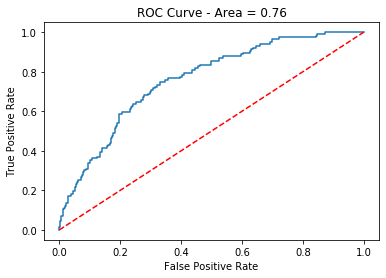

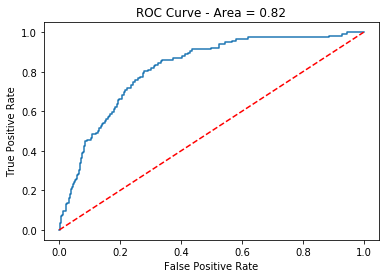

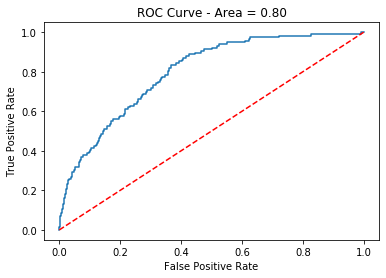

In [74]:
roc_plt(*roc_vals['fl'][:3])
roc_plt(*roc_vals['ch'][:3])
roc_plt(*roc_vals['hs'][:3])

## How to get probabilities from SVM 

https://stats.stackexchange.com/questions/37795/roc-curve-for-discrete-classifiers-like-svm-why-do-we-still-call-it-a-curve

In [75]:
from sklearn import svm

svm_pipeline = make_pipeline(StandardScaler(), svm.SVC())